In [154]:
#%pip install -r requirements.txt

In [1]:
import steamdata
import preprocess
import pandas as pd
import database

In [2]:
app_ids = steamdata.get_app_ids()
print(app_ids)

['730', '2195250', '1091500', '2138330', '32470', '1086940', '1938090', '1627720', '1716740', '1599340', '1260320', '1172620', '306130', '949230', '236390', '1272080', '899770', '359550', '1675200', '570', '1172470', '2362300', '2080690', '2531820', '1084160', '381210', '230410', '1937780', '271590', '1971870', '1551360', '1248130', '1282100', '1244460', '594650', '2440510', '39210', '1326470', '1158310', '394360', '582660', '2290180', '1902690', '33909', '1151340', '1085660', '1449850', '703080', '252490', '27500', '1501750', '1059530', '916440', '124923', '578080', '292030', '255710', '5699', '518790', '2108330', '294100', '10422', '1222670', '1702010', '1289670', '438040', '32454', '427520', '2248760', '1607250', '227300', '1250410', '1286830', '440900', '1096900', '5702', '2230110', '16852', '15456', '2172860', '1401590', '12261', '1063730', '1547000', '1008080', '284160', '962130', '26372', '266410', '2050650', '1985810', '444200', '289070', '25716', '1677740', '1599330', '990080'

In [3]:
# update data
steamdata.update_data()

In [4]:
# get data from database
df = database.get_data_from_database()
df

,app_id,recommendationid,review,voted_up,votes_up,votes_funny,weighted_vote_score
0,730,146314267,this game is amazing\ni got made fun of for be...,1,3965.0,2281.0,0.933550655841827393
1,730,147244655,167 Hard-working achievements gone… How dare y...,0,573.0,50.0,0.895330309867858887
2,730,147189280,"Valve did an Activision-Blizzard, and force up...",0,460.0,2.0,0.889447510242462158
3,730,147147909,"Final Review for the CSGO , end of an era!!!",1,1002.0,42.0,0.880676031112670898
4,730,145932685,"Good game, ruined by cheaters",1,850.0,48.0,0.87881171703338623
...,...,...,...,...,...,...,...
67393,1273400,135318201,fun,1,0.0,0.0,0
67394,1273400,135305444,ד,1,0.0,0.0,0
67395,1273400,135293026,"The game is what it promises, above all.If you...",1,0.0,0.0,0
67396,1273400,135292130,I love coming home from work just to go back t...,1,0.0,0.0,0


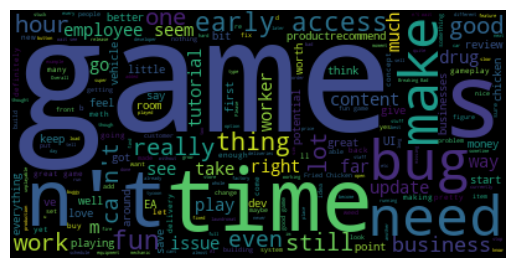

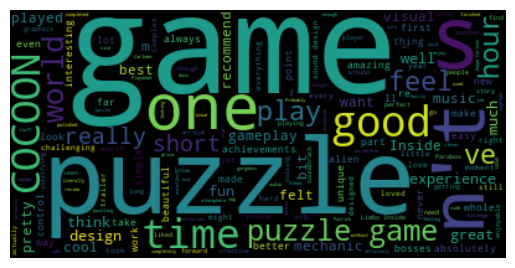

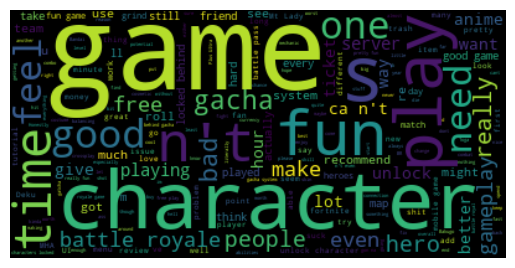

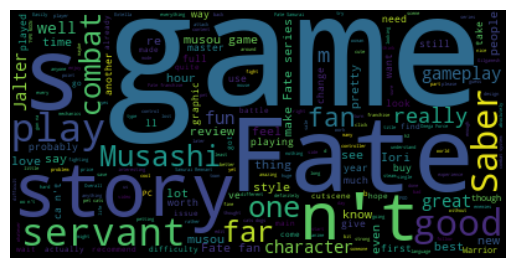

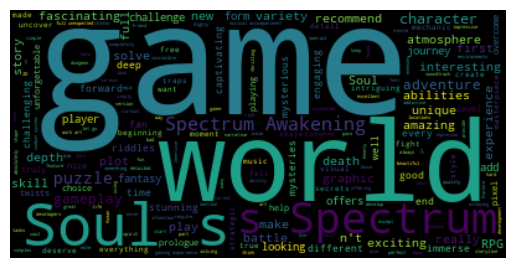

In [145]:
import visualizations
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def tokenize(reviews):
    words = word_tokenize(reviews)
    return [word for word in words if not word.lower() in stop_words]

reviews_per_game = (df.groupby("app_id")
                    .apply(lambda row: [tokenize(review) for review in row["review"]])
                    .tolist())

# TODO for final graphs:
#  Tokenize reviews and then join the tokens together -> stopwords and contractions should be resolved

for reviews in reviews_per_game:
    # join the tokens of each review
    reviews_texts = [' '.join(review) for review in reviews]
    # join the reviews
    all_reviews_for_game = ' '.join(reviews_texts)
    visualizations.visualize_wordcloud(all_reviews_for_game, False)

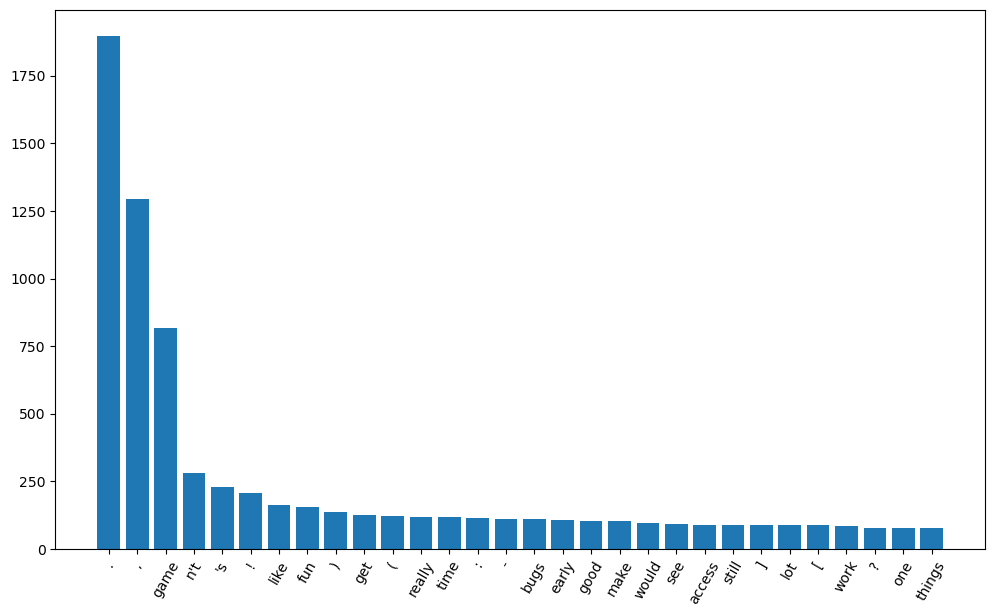

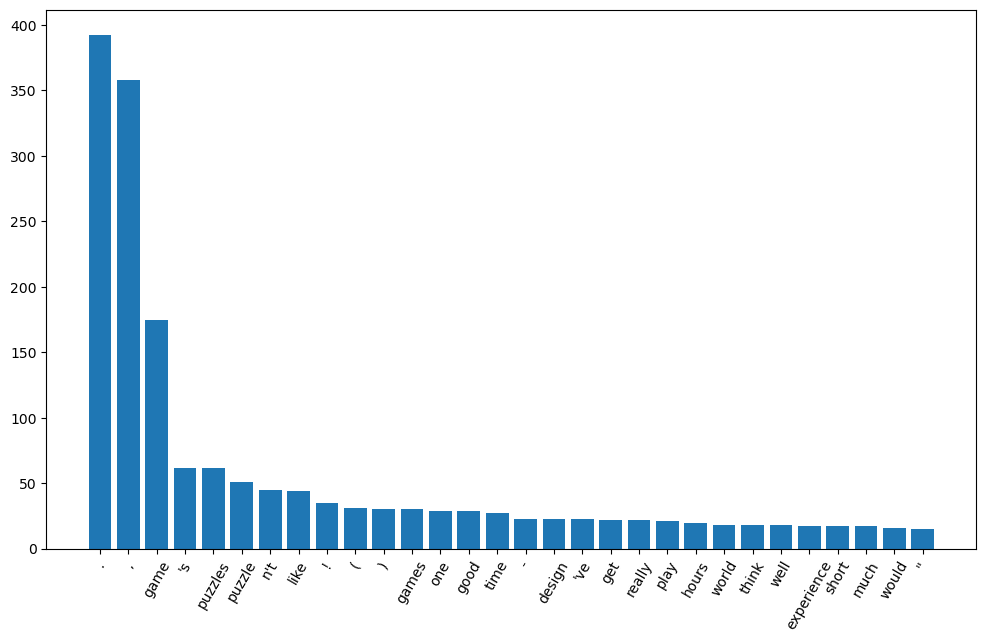

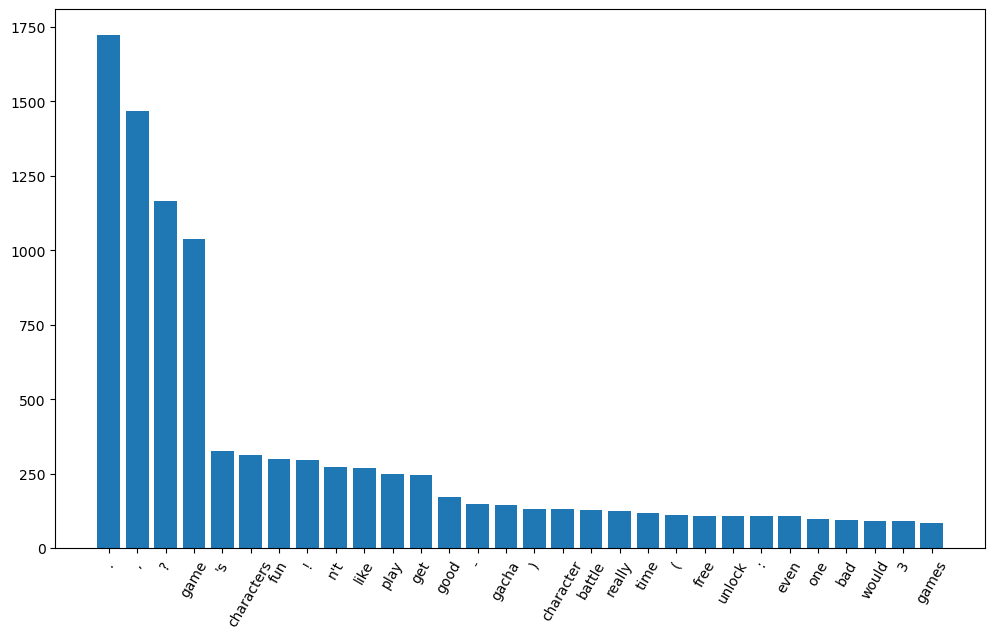

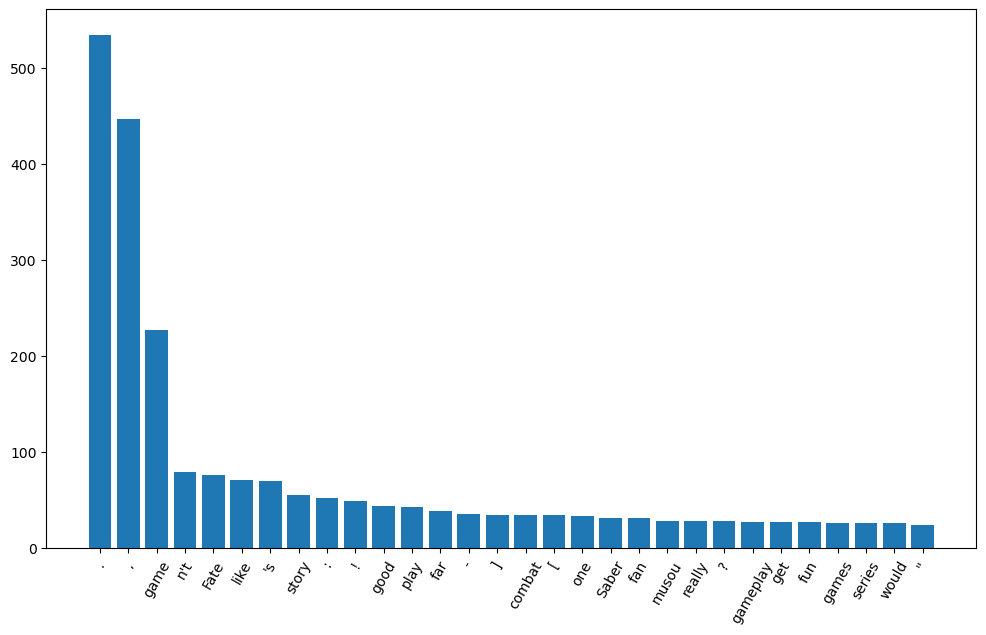

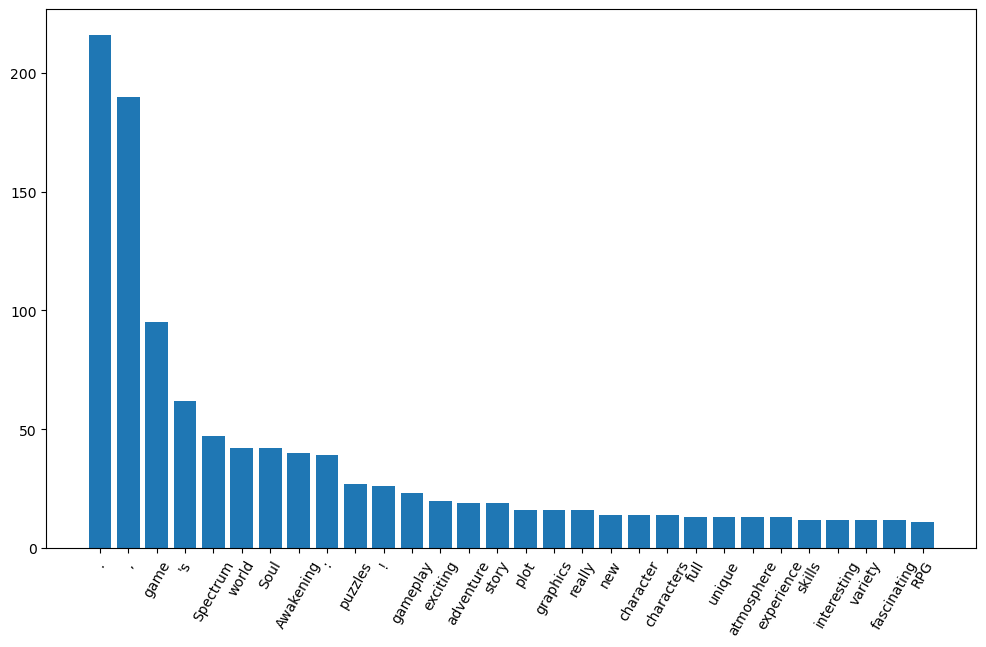

In [149]:
# print most common words per game

for reviews in reviews_per_game:
    tokens_concatenated = [token for review in reviews for token in review]
    # requires list of words
    visualizations.visualize_word_count(tokens_concatenated)

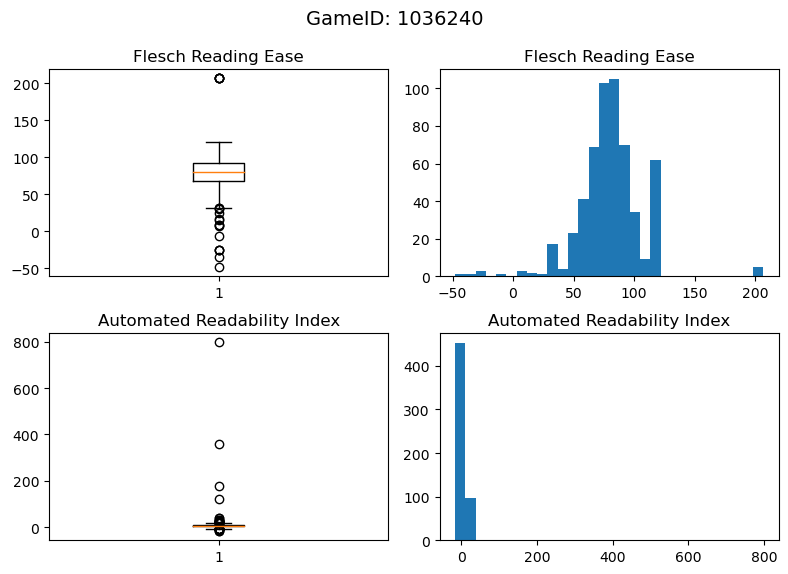

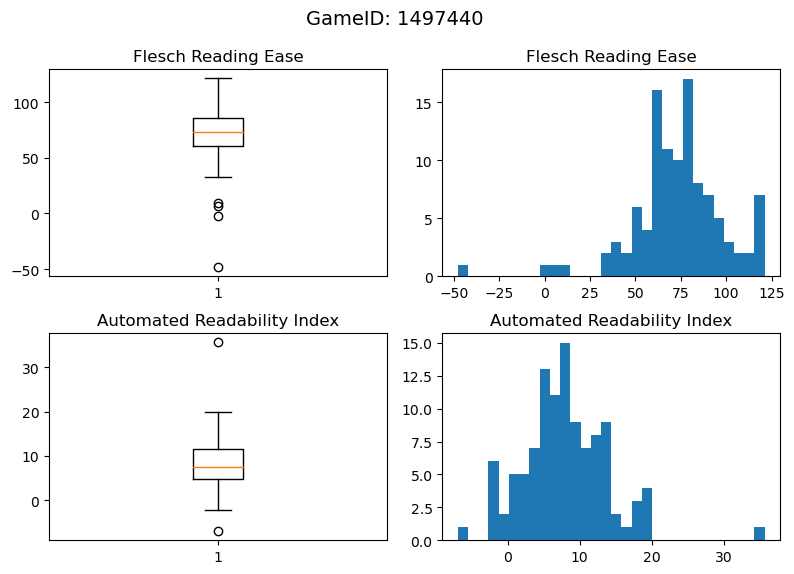

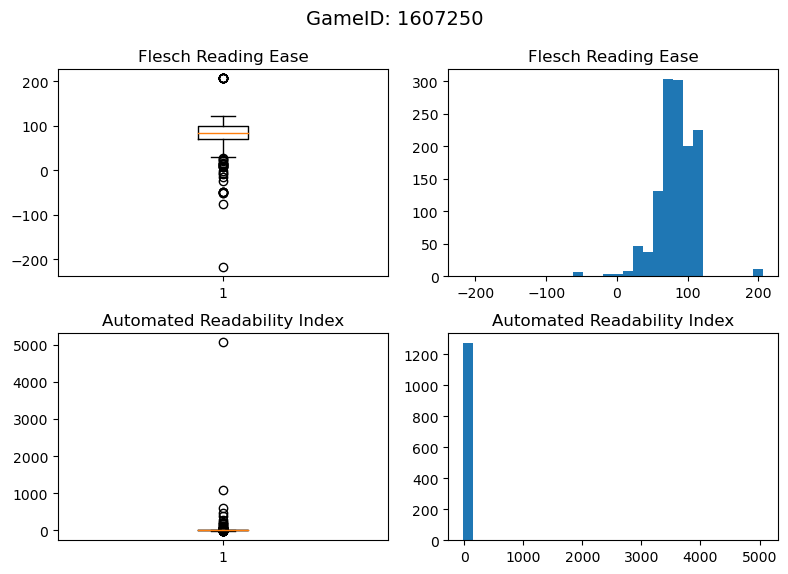

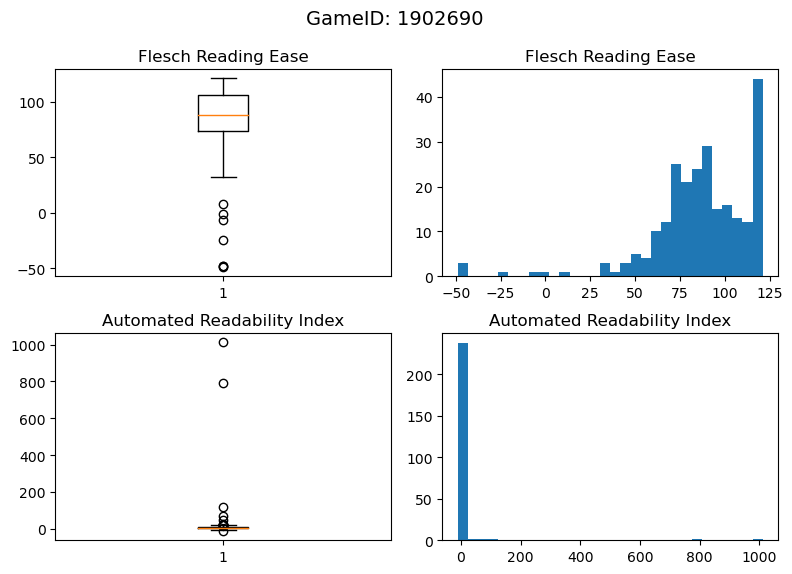

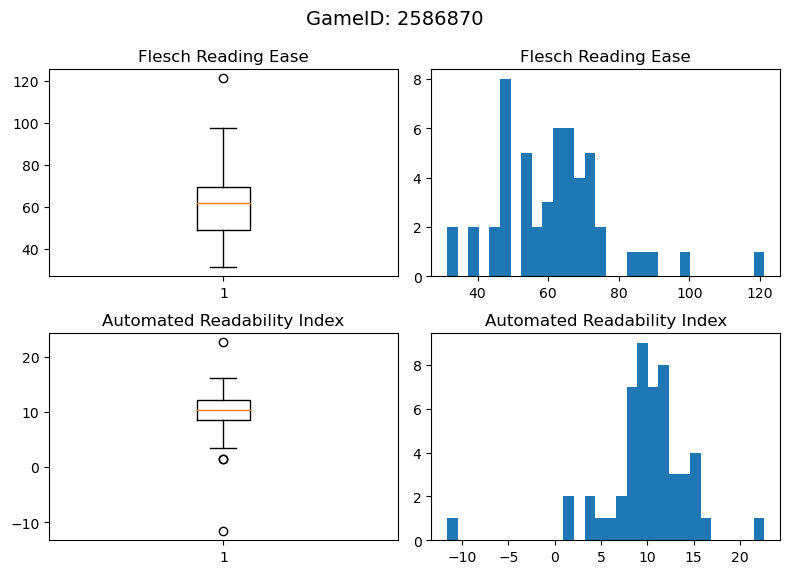

In [153]:
reviews_untokenized_per_game = (df.groupby("app_id")
                                .apply(lambda row: [review for review in row["review"]])
                                .tolist())
game_ids = (df.groupby("app_id")
            .apply(lambda row: row["app_id"])
            .unique()
            .tolist())

for reviews_untokenized, game_id in zip(reviews_untokenized_per_game, game_ids):
    visualizations.readability_scores(reviews_untokenized, "GameID: " + str(game_id))